<a href="https://colab.research.google.com/github/sakshiharde/Driver_Drowsiness_Recognition_Project/blob/main/driver_drowsiness_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
tf.random.set_seed(3)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from collections import Counter

In [2]:
!pip install kaggle

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ismailnasri20/driver-drowsiness-dataset-ddd")

print("Path to dataset files:", path)

100%|██████████| 2.58G/2.58G [00:26<00:00, 105MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/versions/1


In [4]:
# Count the number of files in the directory
file_count = sum(len(files) for _, _, files in os.walk(path))
print("Number of files in the directory:", file_count)


Number of files in the directory: 41793


In [5]:
!pip install split-folders

In [6]:
for root, dirs, files in os.walk(path):
    print("Directory:", root)
    print("Contains directories:", dirs)
    print("Contains files:", files)

Directory: /root/.cache/kagglehub/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/versions/1
Contains directories: ['Driver Drowsiness Dataset (DDD)']
Contains files: []
Directory: /root/.cache/kagglehub/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/versions/1/Driver Drowsiness Dataset (DDD)
Contains directories: ['Drowsy', 'Non Drowsy']
Contains files: []
Directory: /root/.cache/kagglehub/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/versions/1/Driver Drowsiness Dataset (DDD)/Drowsy
Contains directories: []
Contains files: ['ZC0554.png', 'X1436.png', 'O0935.png', 'F0385.png', 'Y0371.png', 'O0198.png', 'X0569.png', 'I1096.png', 'O1330.png', 'A0499.png', 'M0343.png', 'V0391.png', 'T0131.png', 'E0609.png', 'G0054.png', 'W0171.png', 'J0285.png', 'T0375.png', 'Q0576.png', 'W1087.png', 'ZA0386.png', 'P0747.png', 'N1113.png', 'A1156.png', 'I1181.png', 'N0570.png', 'N0481.png', 'H0375.png', 'ZB1165.png', 'E0158.png', 'ZC1274.png', 'ZB0249.png', 'O0071.png', 'C0303.png', 'W0

In [7]:
import splitfolders
import os

# Path to the subdirectory containing 'Drowsy' and 'Non Drowsy'
actual_dataset_path = os.path.join(
    path,
    "Driver Drowsiness Dataset (DDD)"
)

# Verify that the path contains subdirectories
print("Contents of the dataset directory:")
print(os.listdir(actual_dataset_path))

# Split the dataset
output_dir = 'splitted_dataset'
splitfolders.ratio(actual_dataset_path, output=output_dir, seed=1337, ratio=(.8, 0.15, 0.05))

Contents of the dataset directory:
['Drowsy', 'Non Drowsy']


Copying files: 41793 files [00:22, 1834.13 files/s]


In [8]:
train_dir = "splitted_dataset/train"
test_dir = "splitted_dataset/test"
val_dir = "splitted_dataset/val"


In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)


Found 33434 images belonging to 2 classes.


In [11]:
test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary' ,
    shuffle=True
)


Found 2091 images belonging to 2 classes.


In [12]:
val_batches = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)


Found 6268 images belonging to 2 classes.


In [13]:

train_class_indices = train_batches.class_indices
test_class_indices = test_batches.class_indices
val_class_indices = val_batches.class_indices

train_class_labels = train_batches.classes
test_class_labels = test_batches.classes
val_class_labels = val_batches.classes

train_class_counts = Counter(train_class_labels)
test_class_counts = Counter(test_class_labels)
val_class_counts = Counter(val_class_labels)

print("Class Names for train:\n", train_class_indices)
print("Class Counts for train:\n", train_class_counts)
print(end='\n')

print("Class Names for test:\n", test_class_indices)
print("Class Counts for test:\n", test_class_counts)
print(end='\n')

print("Class Names for validation :\n", val_class_indices)
print("Class Counts for validation:\n", val_class_counts)


Class Names for train:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for train:
 Counter({np.int32(0): 17878, np.int32(1): 15556})

Class Names for test:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for test:
 Counter({np.int32(0): 1118, np.int32(1): 973})

Class Names for validation :
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for validation:
 Counter({np.int32(0): 3352, np.int32(1): 2916})


Pixels of the first image after Normalization: 

[[[0.16078432 0.13725491 0.1254902 ]
  [0.14509805 0.11764707 0.10588236]
  [0.13333334 0.10196079 0.09019608]
  ...
  [0.14117648 0.11764707 0.08627451]
  [0.15686275 0.1254902  0.09019608]
  [0.16470589 0.12941177 0.09019608]]

 [[0.18039216 0.14509805 0.1254902 ]
  [0.17254902 0.13725491 0.11764707]
  [0.15686275 0.1254902  0.10980393]
  ...
  [0.13725491 0.10980393 0.07843138]
  [0.16078432 0.12941177 0.09411766]
  [0.18039216 0.14117648 0.10588236]]

 [[0.21176472 0.17254902 0.14117648]
  [0.20392159 0.16470589 0.13725491]
  [0.19215688 0.15294118 0.12941177]
  ...
  [0.1254902  0.10196079 0.07450981]
  [0.15686275 0.12941177 0.09803922]
  [0.18823531 0.15294118 0.12156864]]

 ...

 [[0.8196079  0.80392164 0.6862745 ]
  [0.8196079  0.80392164 0.6862745 ]
  [0.8196079  0.80392164 0.6862745 ]
  ...
  [0.7843138  0.70980394 0.6       ]
  [0.7843138  0.7254902  0.6039216 ]
  [0.77647066 0.73333335 0.6039216 ]]

 [[0.8196079  0.80392164 

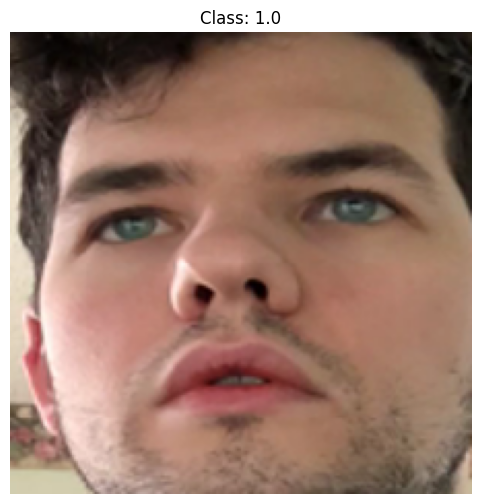

In [14]:

import matplotlib.pyplot as plt

# Retrieve a batch of images and labels from the training set
images, labels = next(train_batches)

# Print the pixel values of the first image after normalization
# Normalization should have scaled the pixel values to a range of [0, 1]
print(f"Pixels of the first image after Normalization: \n\n{images[0]}")

# Plot the first image to visually inspect the preprocessing
plt.figure(figsize=(6,6))  # Set the figure size for better visualization
plt.imshow(images[0])  # Display the first image in the batch
plt.axis('off')  # Remove axis labels for a cleaner display
plt.title(f"Class: {labels[0]}")  # Show the class label (Drowsy or Non-Drowsy) on the plot
plt.show()

In [15]:
print(f"there are { images[0].ndim} Channels ")
print(f"image shape : {images[0].shape}")

there are 3 Channels 
image shape : (224, 224, 3)


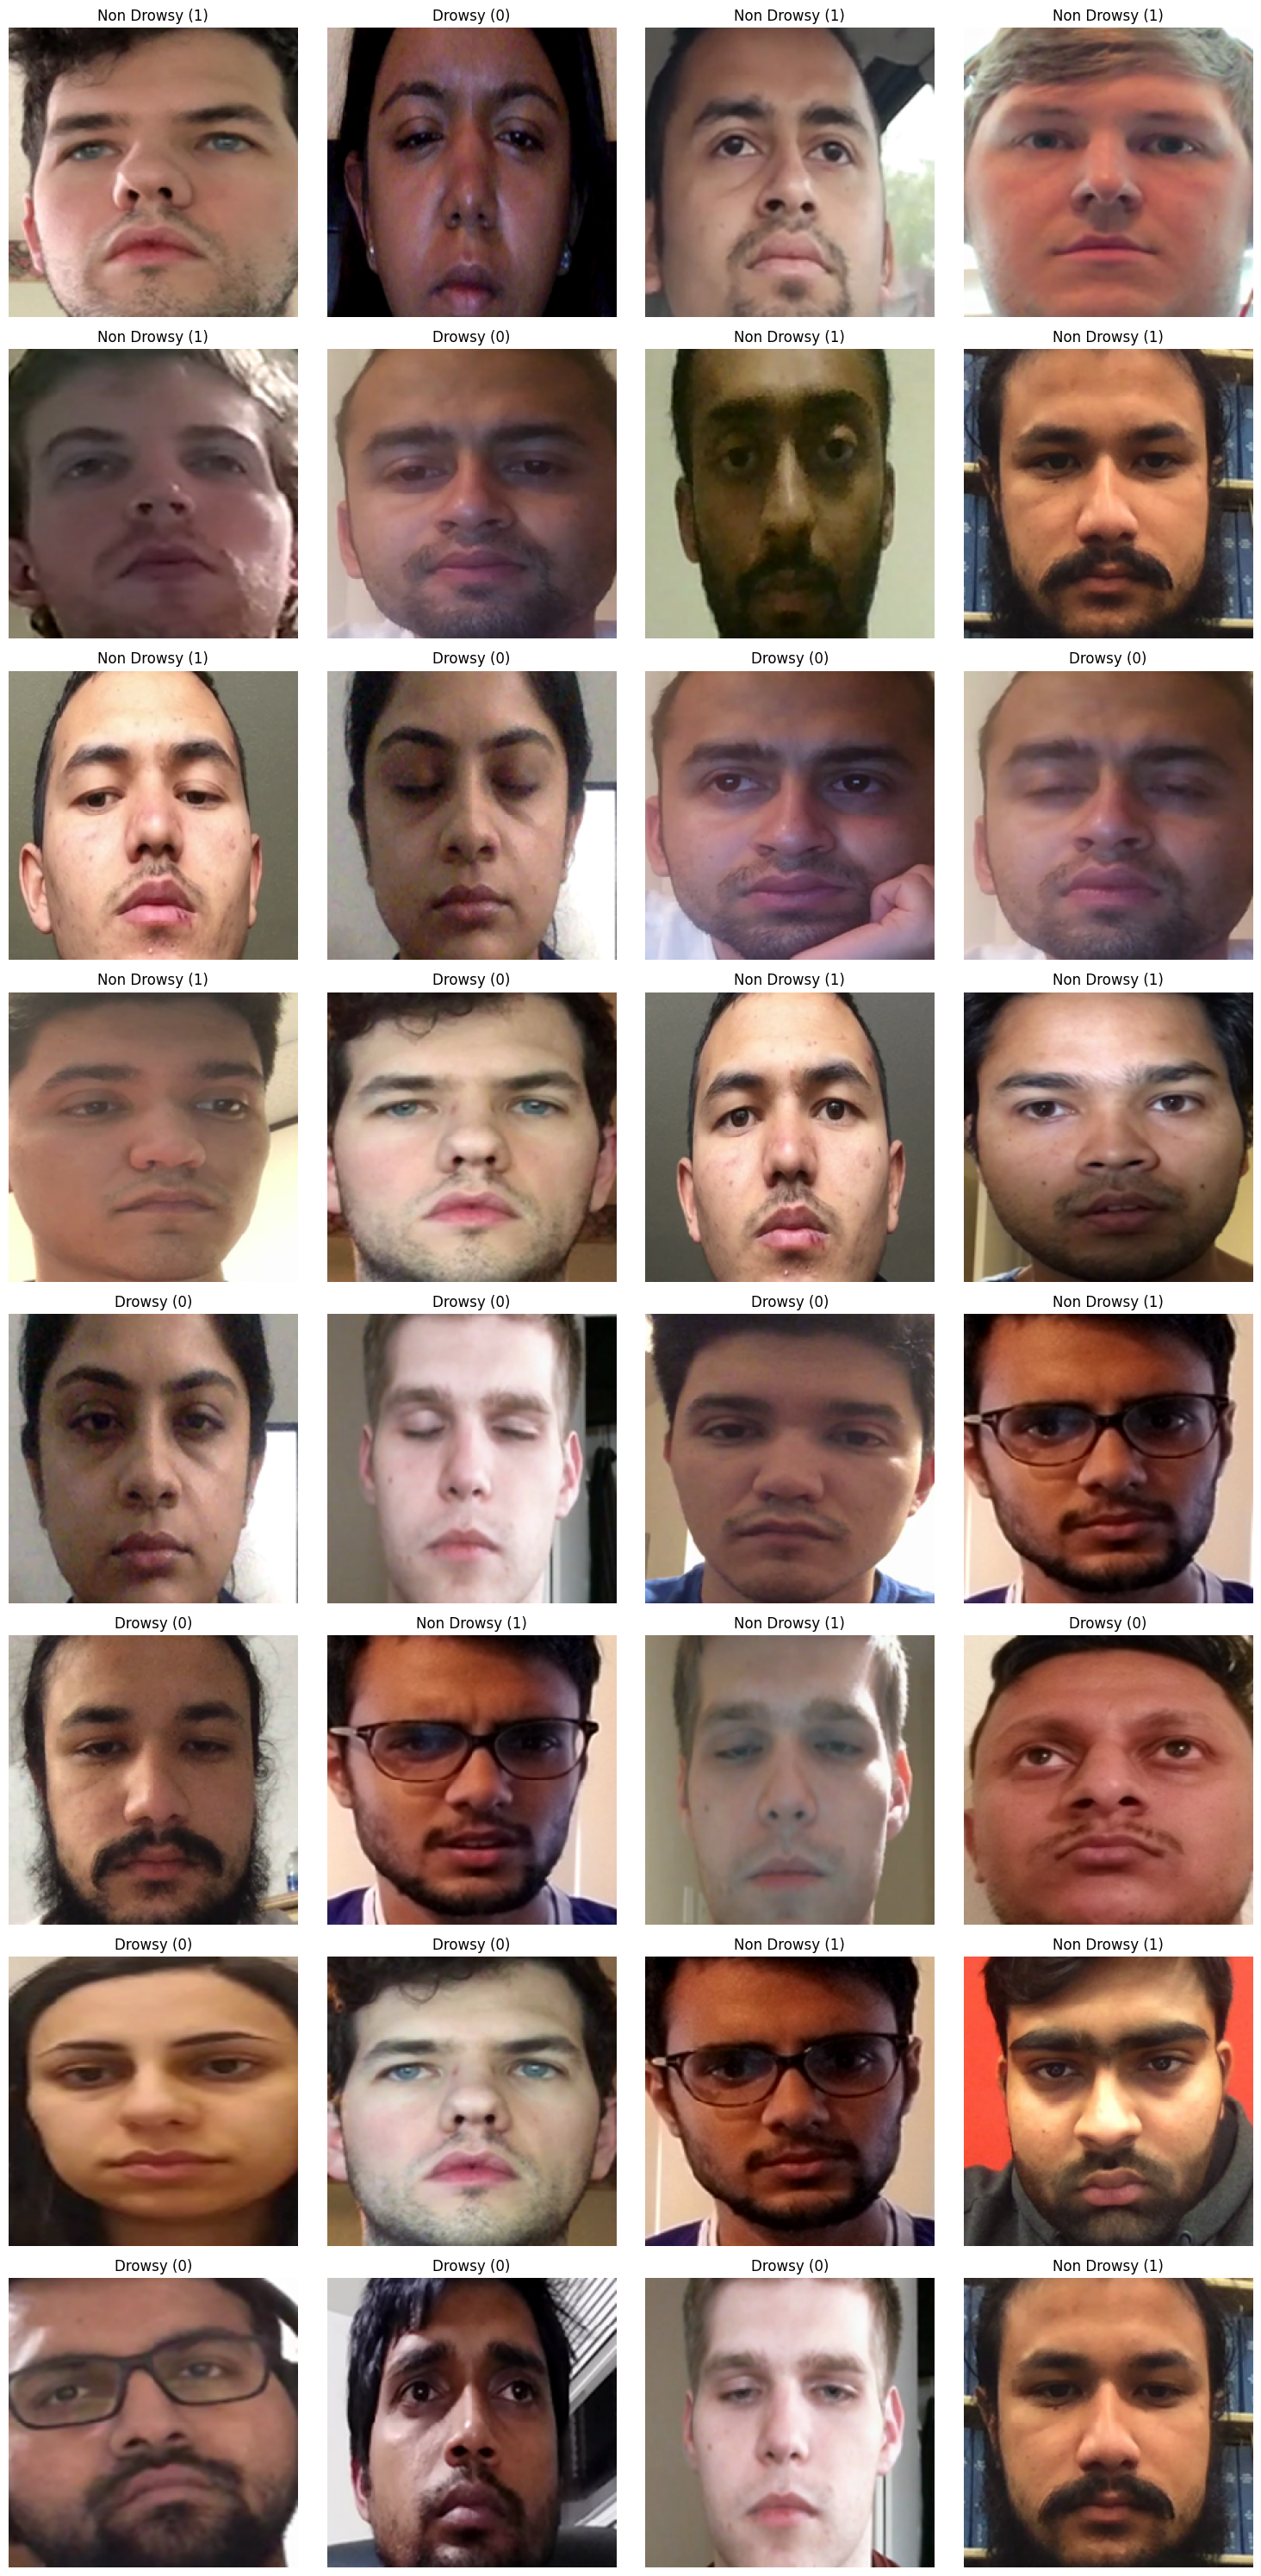

In [16]:
import matplotlib.pyplot as plt

# Create a grid of 8 rows and 4 columns for displaying images
fig, axes = plt.subplots(8, 4, figsize=(15, 30))

# Get class indices to map labels to their corresponding class names
class_indices = train_batches.class_indices

# Loop through the 8 rows and 4 columns to display 32 images
for i in range(8):
    images, labels = next(train_batches)

    for j in range(4):
        ax = axes[i, j]

        # Display the image
        ax.imshow(images[j])

        # Hide the axes for better clarity
        ax.axis('off')

        # Get the label for the image and map it to the class name
        label = int(labels[j])
        label_name = list(class_indices.keys())[list(class_indices.values()).index(label)]

        # Set the title with the class name and label
        ax.set_title(f'{label_name} ({label})', fontsize=12)
# Adjust the layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()

In [17]:
# Define the image size
image_size = (224, 224)

# Initialize the MobileNetV2 model with the defined input shape
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3),
)

# Check the type of the base model
print(type(base_model))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
<class 'keras.src.models.functional.Functional'>


In [18]:
# Get the summary of model
base_model.summary()


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [19]:
# Initializing a Sequential model
model = keras.Sequential()

# Freezing the layers of the base model (except the last 25 layers)
# This prevents their weights from being updated during training
for layer in base_model.layers[:-25]:
    layer.trainable = False

# Adding a Flatten layer to transform the 2D outputs of the base model into a 1D vector
x = base_model.output
x = Flatten()(x)

# Adding fully connected Dense layers to the model
# The first Dense layer has 1024 units and uses ReLU activation for non-linearity
x = Dense(1024, activation='relu')(x)

# The second Dense layer has 512 units, again with ReLU activation
x = Dense(512, activation='relu')(x)

# The output layer with 2 units for the binary classification (Drowsy vs. Non-Drowsy)
# We use the softmax activation function to output probabilities for each class
predictions = Dense(2, activation='softmax')(x)

# Creating the final model, where the input is the base model input and output is the predictions
model = Model(inputs=base_model.input, outputs=predictions)

# Summarizing the model architecture to inspect the layers and parameters
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 67,010,114 (255.62 MB)

 Trainable params: 66,114,050 (252.21 MB)

 Non-trainable params: 896,064 (3.42 MB)

In [20]:
# Compiling the model
model.compile(
    optimizer=Adam(0.0001),  # Adam optimizer with a learning rate of 0.0001
    loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Metric to track during training
)


In [21]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy'
    patience=3,  # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore the best weights when training is stopped
)

# Train the model with EarlyStopping
history = model.fit(
    train_batches,
    epochs=20,
    validation_data=val_batches,
    batch_size=32,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 4462s 2s/step - accuracy: 0.9806 - loss: 0.0734 - val_accuracy: 0.9998 - val_loss: 0.0028
Epoch 2/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 4334s 2s/step - accuracy: 0.9975 - loss: 0.0149 - val_accuracy: 1.0000 - val_loss: 1.2641e-04
Epoch 3/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 4326s 2s/step - accuracy: 0.9995 - loss: 0.0039 - val_accuracy: 0.9989 - val_loss: 0.0173
Epoch 4/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 4359s 2s/step - accuracy: 0.9992 - loss: 0.0047 - val_accuracy: 0.9997 - val_loss: 0.0021
Epoch 5/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 4407s 2s/step - accuracy: 0.9992 - loss: 0.0065 - val_accuracy: 0.9986 - val_loss: 0.0073


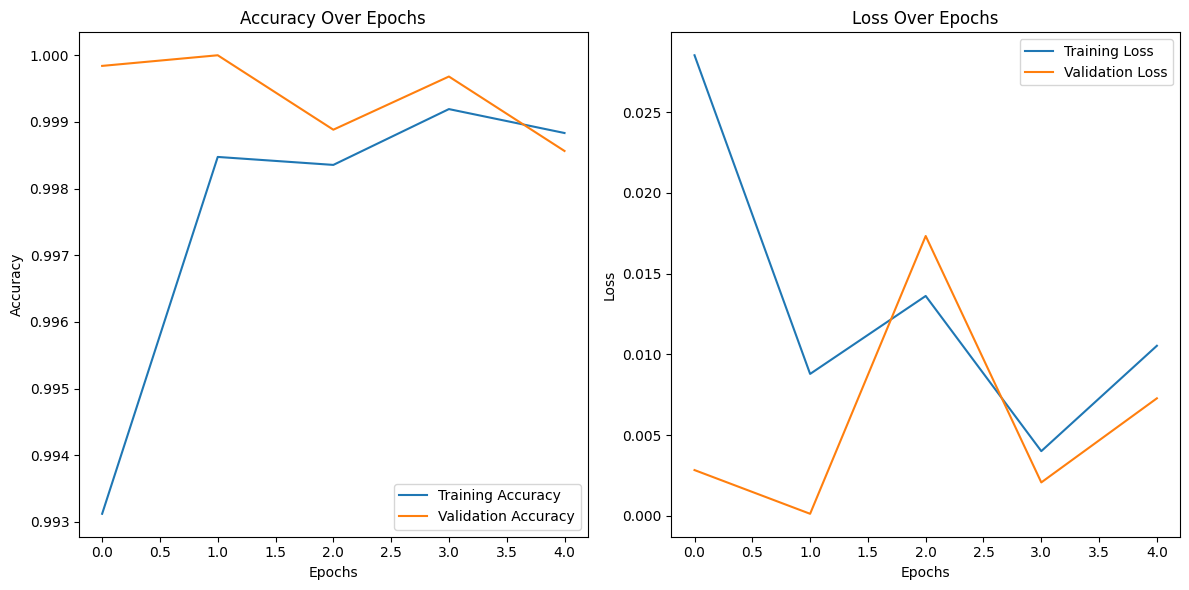

In [22]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
# Ensure the directory exists
save_dir = "saved_model"
os.makedirs(save_dir, exist_ok=True)

# Define save paths
model_path = os.path.join(save_dir, "model.keras")
weights_path = os.path.join(save_dir, "model.weights.h5")

# Save the full model
model.save(model_path)

# Save only the weights
model.save_weights(weights_path)

print(f"Model saved successfully at {model_path}")

Model saved successfully at saved_model/model.keras


In [24]:
# Convert the saved model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
tflite_model_path = "saved_model/model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"Model saved at {tflite_model_path}")

Saved artifact at '/tmp/tmp_qx6atw4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  134352238966736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134352238965968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134351236538896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134352238963664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134352238966544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134352238964432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134351236543120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134351236531600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134351236537360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134351236531408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13435123653217

In [25]:
import os
import random
import time
import numpy as np
from PIL import Image
import tensorflow as tf

# Define paths
valid_images_path = "/content/splitted_dataset/test"
subfolders = ["Drowsy", "Non Drowsy"]  # Names of the subdirectories

# Sample size per category
sample_size = 100

# Collect a sample of image paths
image_paths, true_labels = [], []
for subfolder in subfolders:
    folder_path = os.path.join(valid_images_path, subfolder)
    all_images = [img for img in os.listdir(folder_path) if img.endswith(('.jpg', '.png'))]

    # Randomly select images
    sampled_images = random.sample(all_images, min(sample_size, len(all_images)))

    for img in sampled_images:
        image_paths.append(os.path.join(folder_path, img))
        true_labels.append(subfolder)  # Ground truth is the folder name

# Load model
model = tf.keras.models.load_model("saved_model/model.keras")
# Function to preprocess image
def preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))  # Adjust to model input size
    img = np.array(img) / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Evaluate model
correct_predictions = 0
total_images = len(image_paths)
inference_times = []

for image_path, true_label in zip(image_paths, true_labels):
    img = preprocess_image(image_path)

    # Measure inference time
    start_time = time.time()
    predictions = model.predict(img)
    end_time = time.time()

    inference_time = end_time - start_time
    inference_times.append(inference_time)

    # Get predicted class
    predicted_class_index = np.argmax(predictions)
    predicted_class = subfolders[predicted_class_index]  # Assuming class order matches

    # Check if prediction is correct
    is_correct = predicted_class == true_label
    correct_predictions += int(is_correct)

    print(f"Image: {os.path.basename(image_path)} - Predicted: {predicted_class} ({np.max(predictions) * 100:.2f}%) - Actual: {true_label} → {'✅ Correct' if is_correct else '❌ Incorrect'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image: L0622.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Image: X0294.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Image: T0479.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Image: J0423.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Image: A0050.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Image: R0064.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Image: P0555.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Image: ZA0510.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Image: Y1114.png - Predicted: Drowsy (100.00%) -

In [26]:
# Final metrics
accuracy = (correct_predictions / total_images) * 100 if total_images > 0 else 0
avg_inference_time = np.mean(inference_times) if inference_times else 0

print(f"\nFinal Score: {correct_predictions}/{total_images} correct ({accuracy:.2f}% accuracy)")
print(f"Average Inference Time per Image: {avg_inference_time:.4f} seconds ({1/avg_inference_time:.2f} FPS)")


Final Score: 200/200 correct (100.00% accuracy)
Average Inference Time per Image: 0.2094 seconds (4.78 FPS)


In [32]:
!pip install ultralytics
!pip install python-dotenv
!pip install roboflow


In [35]:
from ultralytics import YOLO
from IPython.display import display , Image
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 50.3/107.7 GB disk)


In [37]:
from roboflow import Roboflow
from dotenv import load_dotenv
import os

# Load environment variables from the .env file
load_dotenv()

# Retrieve API key, workspace, and project information
api_key = os.getenv("ROBOFLOW_API_KEY")
workspace = os.getenv("ROBOFLOW_WORKSPACE")
project_name = os.getenv("ROBOFLOW_PROJECT")

# Validate that all required environment variables are set
if not api_key or not workspace or not project_name:
    raise ValueError("One or more environment variables are missing. Check your .env file.")

# Initialize Roboflow API
rf = Roboflow(api_key=api_key)
project = rf.workspace(workspace).project(project_name)
dataset = project.version(3).download("folder")
dataset_dir = dataset.location

# Print the full path of the downloaded dataset directory
print(f"Dataset downloaded to: {dataset_dir}")

# Walk through the downloaded dataset directory structure
# This helps inspect the hierarchy of folders and files
for root, dirs, files in os.walk(dataset_dir):
    print(f"Current Directory: {root}")  # Current folder path
    print(f"Subdirectories: {dirs}")    # List of subfolders
    print(f"Files: {files}")            # List of files
    print("-" * 40)

# Example of creating paths to specific subdirectories dynamically
# Path to training images
train_images_path = os.path.join(dataset_dir, "train", "images")
# Path to validation images
valid_images_path = os.path.join(dataset_dir, "valid", "images")

# Print paths for confirmation
print(f"Train images are located at: {train_images_path}")
print(f"Validation images are located at: {valid_images_path}")

ValueError: One or more environment variables are missing. Check your .env file.

In [ ]:
import glob
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the images directory (adjust if needed)
image_paths = glob.glob(f"{dataset_dir}/train/**/*.*", recursive=True)[24:36]

# Check if there are enough images
if len(image_paths) < 12:
    raise ValueError(f"Not enough images found! Found only {len(image_paths)} images.")

# Create a figure with subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Iterate over the image paths and display images in subplots
for i, image_path in enumerate(image_paths):
    # Calculate the row and column indices of the current subplot
    row = i // 4
    col = i % 4

    try:
        # Open the image using PIL
        img = Image.open(image_path)

        # Display the image in the current subplot
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(image_path.split('/')[-1])  # Display the image filename
    except Exception as e:
        print(f"Error displaying {image_path}: {e}")
        axes[row, col].axis('off')
        axes[row, col].set_title("Error loading image")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import os
import zipfile
from ultralytics import YOLO

# Paths
runs_directory = "runs/classify/train/weights"
best_model_path = os.path.join(runs_directory, "best.pt")
backup_zip = "runs_backup.zip"

# Check if trained model exists
if os.path.exists(best_model_path):
    print(f"✅ Found trained model at '{best_model_path}', loading YOLO...")
    model = YOLO(best_model_path)

# If no trained model, check for a backup ZIP
elif os.path.exists(backup_zip):
    print(f"📂 Found '{backup_zip}', extracting to '{runs_directory}'...")
    with zipfile.ZipFile(backup_zip, 'r') as zip_ref:
        zip_ref.extractall("runs")
    print("✅ Extraction complete. Loading model...")

    if os.path.exists(best_model_path):
        model = YOLO(best_model_path)
    else:
        print("⚠️ Extraction failed or best.pt not found. Training required.")
        model = YOLO("yolo11n-cls.pt")
        model.train(data=dataset_dir, epochs=20)
        print("✅ Training complete.")

# If no trained model or backup, train from scratch
else:
    print("🚀 No trained model or backup found. Starting training...")
    model = YOLO("yolo11n-cls.pt")
    model.train(data=dataset_dir, epochs=20)
    print("✅ Training complete.")

    # Create a backup of the runs directory
    print("📦 Creating backup of trained model...")
    with zipfile.ZipFile(backup_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk("runs"):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, "runs"))
    print(f"✅ Backup saved as '{backup_zip}'")

In [ ]:
import os
import random

# Paths to the validation image folders
valid_images_path = "/content/safedrive_drowsiness_detection-3/valid"
subfolders = ["Drowsy", "Non Drowsy"]  # Names of the subdirectories

# Number of images to sample per category
sample_size = 100

# Collect a sample of image paths from both folders
image_paths = []
true_labels = []
for subfolder in subfolders:
    folder_path = os.path.join(valid_images_path, subfolder)
    all_images = [img for img in os.listdir(folder_path) if img.endswith(('.jpg', '.png'))]

    # Select a random sample (or all if fewer than sample_size)
    sampled_images = random.sample(all_images, min(sample_size, len(all_images)))

    for img in sampled_images:
        image_paths.append(os.path.join(folder_path, img))
        true_labels.append(subfolder)  # Ground truth is the folder name

# Counters for evaluation
correct_predictions = 0
total_images = len(image_paths)

# Iterate through the sampled images and perform prediction
for image_path, true_label in zip(image_paths, true_labels):
    results = model(image_path)

    for result in results:
        # Convert probs to a list of numerical values
        probs = result.probs.data.tolist()
        classes = result.names

        highest_prob = max(probs)
        highest_prob_index = probs.index(highest_prob)
        predicted_class = classes[highest_prob_index]

        # Check if the prediction matches the true label
        is_correct = "✅ Correct" if predicted_class == true_label else "❌ Incorrect"
        if predicted_class == true_label:
            correct_predictions += 1

        print(f"Image: {image_path} - Predicted: {predicted_class} ({highest_prob*100:.2f}%) - Actual: {true_label} → {is_correct}")

# Final accuracy score
accuracy = (correct_predictions / total_images) * 100 if total_images > 0 else 0
print(f"\nFinal Score: {correct_predictions}/{total_images} correct ({accuracy:.2f}% accuracy)")


In [ ]:
from google.colab.patches import cv2_imshow
import cv2

confusion_matrix_path = "./runs/classify/train/confusion_matrix.png"

# Read and display the confusion matrix image
cv2_imshow(cv2.imread(confusion_matrix_path))

In [ ]:
confusion_matrix_normalized_path = "./runs/classify/train/confusion_matrix_normalized.png"

# Read and display the confusion matrix image
cv2_imshow(cv2.imread(confusion_matrix_normalized_path))

In [ ]:
results_path = "./runs/classify/train/results.png"

# Read and display the results image
cv2_imshow(cv2.imread(results_path))

In [ ]:
import shutil
import os

# Define the directory to compress
runs_directory = "./runs"
zip_filename = "runs_backup.zip"

# Check if the directory exists
if os.path.exists(runs_directory):
    # Create a ZIP archive
    shutil.make_archive(zip_filename.replace(".zip", ""), 'zip', runs_directory)
    print(f"✅ Compression complete: {zip_filename}")
else:
    print("⚠️ The 'runs' directory does not exist. Nothing to compress.")

In [ ]:
project.version(3).deploy(model_type="yolov11-cls", model_path="./runs/classify/train/")

In [ ]:
# Export the model to TensorFlow Lite format
model.export(format="tflite")

print("✅ Model successfully converted to TensorFlow Lite.")